In [1]:
from matplotlib import pyplot as plt
import networkx as nx
from networkx import bipartite
import random
import scipy.stats as spstats
import tqdm
%matplotlib inline

In [2]:
def get_stages(N, M, D):
    stages = []
    for i in range(D):
        groups = get_stage_groups(N, M, i)
        stages.append(groups)
    return stages

def get_stage_groups(N, M, stage):
    primes = [2, 3, 5, 7, 11, 13, 17]
    p = primes[stage]
    partition = []
    for j in range(p):
        # Generate 
        residue_class = [n for n in range(N) if n % p == j]
        chunks = [
            set(residue_class[k:k+M]) 
            for k in range(0, len(residue_class), M)]
        partition += chunks
    return partition

def get_groups(N, M, D):
    stages = get_stages(N, M, D)
    groups = sum(stages, [])
    return groups

def get_random_stage_groups(N, M, i):
    nodes = list(range(N))
    random.shuffle(nodes)
    groups = [set(nodes[k:k+M]) for k in range(0, N, M)]
    return groups

def get_random_groups(N, M, D):
    groups = sum([get_random_stage_groups(N, M, i) for i in range(D)], [])
    return groups

In [3]:
def get_layer_graph(stage_groups):
    G = nx.DiGraph()
    all_nodes = sum(map(list, stage_groups[0]), [])
    for stage, groups in enumerate(stage_groups):
        for i, nodes in enumerate(groups):
            # Add within-stage edges
            for s in nodes:
                for t in nodes:
                    s_label = '{}-{}'.format(stage, s)
                    t_label = '{}-{}'.format(stage + 1, t)
                    if s == t:
                        # Node's connection to itself doesn't count as hop
                        G.add_edge(s_label, t_label, weight=0)
                    else:
                        # Connections between nodes in same gorup
                        G.add_edge(s_label, t_label, weight=1)
    return G

In [4]:
def test_residue(M=5, D=3, all_N=range(20,80)):
    result = {
        'harmonic': [],
        'kcon': []
    }
    for N in tqdm.tqdm(all_N):
        harmonic_total = 0
        kcon_total = 0
        for m in range(10):
            # Generate graph
            stage_groups = [get_stage_groups(N, M, i) for i in range(D)]
            G_residue = get_layer_graph(stage_groups)
            residue_paths = dict(nx.shortest_path_length(G_residue, weight='weight'))
            residue_lengths = []
            for s in range(N):
                for t in range(N):
                    if s == t:
                        continue
                    s_id = '0-{}'.format(s)
                    t_id = '{}-{}'.format(D, t)
                    try:
                        residue_lengths.append(residue_paths[s_id][t_id])
                        if residue_paths[s_id][t_id] <= D:
                            kcon_total += 1
                    except KeyError:
                        residue_lengths.append(float('inf'))
            harmonic_total += spstats.hmean(residue_lengths)
        result['harmonic'].append(harmonic_total / 10)
        result['kcon'].append(kcon_total / N / (N - 1) / 10)
    return result

In [5]:
def test_random(M=5, D=3, all_N=range(20,80)):
    result = {
        'harmonic': [],
        'kcon': []
    }
    for N in tqdm.tqdm(all_N):
        harmonic_total = 0
        kcon_total = 0
        for m in range(10):
            # Random
            stage_groups = [get_random_stage_groups(N, M, i) for i in range(D)]
            G_random = get_layer_graph(stage_groups)
            random_paths = dict(nx.shortest_path_length(G_random, weight='weight'))
            lengths = []
            for s in range(N):
                for t in range(N):
                    if s == t:
                        continue
                    s_id = '0-{}'.format(s)
                    t_id = '{}-{}'.format(D, t)
                    try:
                        lengths.append(random_paths[s_id][t_id])
                        if random_paths[s_id][t_id] <= D:
                            kcon_total += 1
                    except KeyError:
                        lengths.append(float('inf'))
            harmonic_total += spstats.hmean(lengths)
        result['harmonic'].append(harmonic_total / 10)
        result['kcon'].append(kcon_total / N / (N - 1) / 10)
    return result


In [6]:
all_N = range(20, 200)
residue_result = test_residue(M=5, D=3, all_N=all_N)

100%|██████████| 180/180 [01:22<00:00,  1.04s/it]


In [7]:
random_result = test_random(M=5, D=3, all_N=all_N)

100%|██████████| 180/180 [01:35<00:00,  1.15s/it]


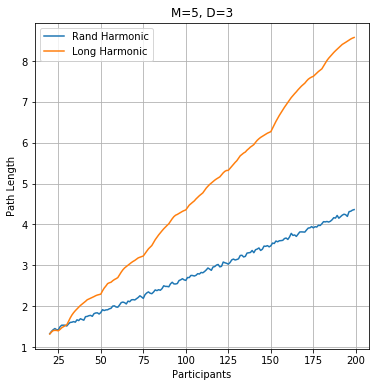

In [8]:
plt.figure(figsize=(6,6))
plt.title("M=5, D=3")
plt.plot(all_N, random_result['harmonic'], label="Rand Harmonic")
plt.plot(all_N, residue_result['harmonic'], label="Long Harmonic")
plt.legend()
plt.xlabel("Participants")
plt.ylabel("Path Length")
plt.grid()
plt.savefig('NetDelib-2019-02-22.png', dpi=300)

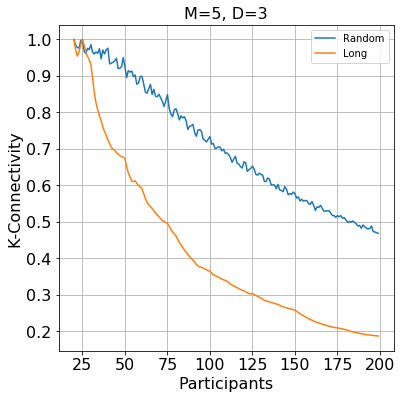

In [11]:
plt.figure(figsize=(6,6))
plt.title("M=5, D=3", fontsize=16)
plt.plot(all_N, random_result['kcon'], label="Random")
plt.plot(all_N, residue_result['kcon'], label="Long")
plt.legend()
plt.xlabel("Participants", fontsize=16)
plt.ylabel("K-Connectivity", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.savefig('NetDelib-2019-02-22.png', dpi=300)